<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🥇 평가 루브릭  
|**평가문항** | **상세기준** |  
|---|---|
| 1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드가 모두 적절히 사용되었음 |
| 2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨 |
| 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? | 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨 |

# 📈  프로젝트 : 주식 예측에 도전해 보자!

## STEP 1 : 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [ ]:
pip install statsmodels --upgrade
# 재접속 시 코랩 버전이 다시 구버전으로 돌아가서 적어준 코드
# 이 다음부터 실행

SyntaxError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
def ReadData(path):
    df = pd.read_csv(path, index_col = 'Date', parse_dates=True) 
    # date로 인덱싱 parse_dates 를 True로 하면 인덱싱 한 Date 컬럼을 datetime자료형으로 바꿔줌
    return df

In [ ]:
path = '/content/drive/MyDrive/dataset/005930.KS.csv'

df = ReadData(path)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [ ]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

* 결측치 처리
* 로그 변환

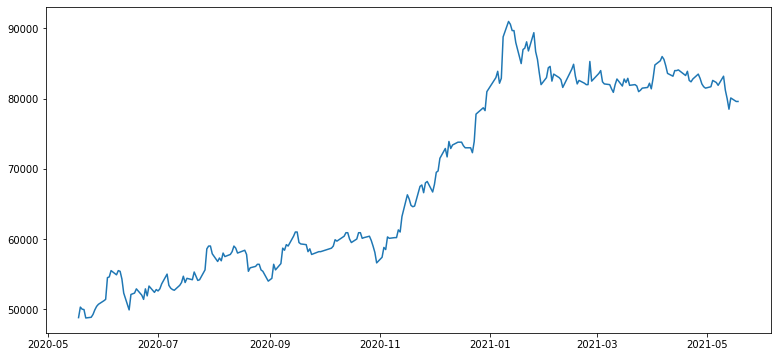

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

한 눈에 봐도 시간에 따라 값이 증가되고 있습니다.  
결측치를 확인해보겠습니다.

In [ ]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치가 없네요.. 만약 있다면 보간하는 것을 추천하는데,  

In [ ]:
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


이렇게하면됩니다!

2020-05 부터 2020-11 구간을 보면 시간에 따라 증가하는 추세므로, 이때는 로그 변환을 해줘서 분산을 줄여줍니다.

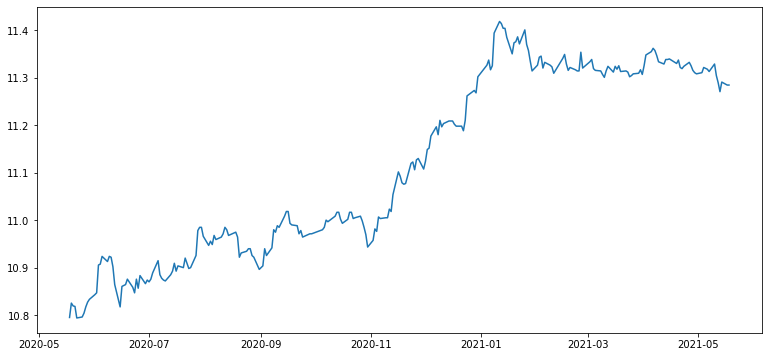

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

별 차이는 없네요.. 가아니라 y축의 단위가 굉장히 작아졌습니다!!! 

## STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

정성적으로 그래프를 분석하기 위해 일정시간 내 구간 통계치를 시각화해보는 함수를 가져왔습니다.

In [ ]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean') #이동평균(rolmean)
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

stationary 여부 체크  
statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 시계열 데이터에 대한 Augmented Dickey-Fuller Test를 수행하기 위해 함수를 가져왔습니다.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

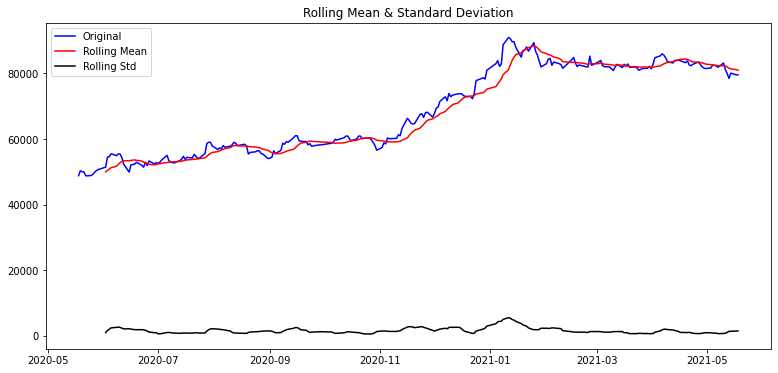

In [ ]:
plot_rolling_statistics(ts, window=12)

로그 취하기 전 ts그래프를 비교하기 위해 rolling mean, standard 를 시각화 해보았습니다.

In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


마찬가지로 augment dickey fuller test 도 해보았습니다.

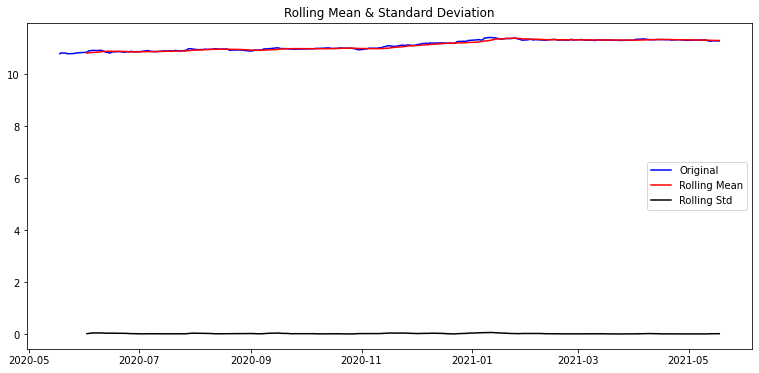

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


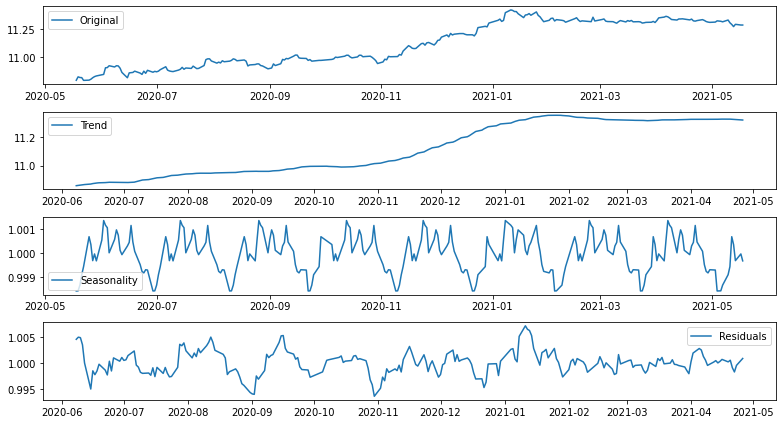

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# model = 'additive' or 'multiplicative' 
# additive = 레벨+트렌드+계절성+잡음 
# multiplicative = 레벨*트렌드*계절성*잡음
# period = '주기' 근데이제 일별 데이터라서 30으로 둔 듯, 월별 데이터면 12로 둘듯.

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

이동평균을 구해 ts_log에서 빼줌 : trend 상쇄  
차분(원래 시계열 - 시프트한 시계열) : 계절성 상쇄

그래프가 확연하게 stationary 해졌습니다. 그러나 아직 p-value값을 봤을 때  안정적이라고 말 할수는 없다고 생각합니다.   
original 시계열에서 trend와 seasonality를 제거하고 난 나머지인 Residual을 이용해서 안정성 여부를 따져 보겠습니다.

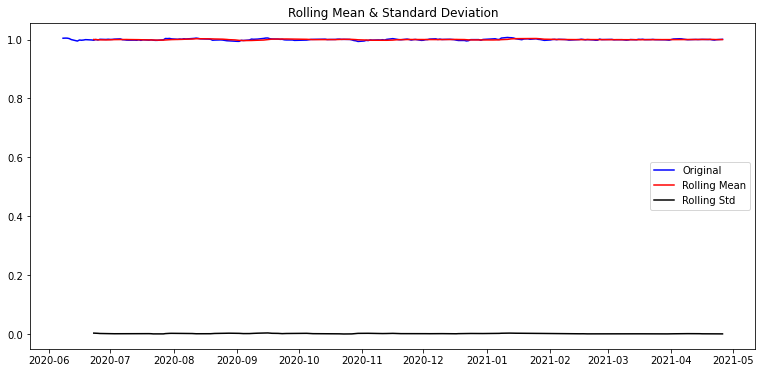

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


decomposing을 하니 p-value가 굉장히 낮아졌네요

## STEP 4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

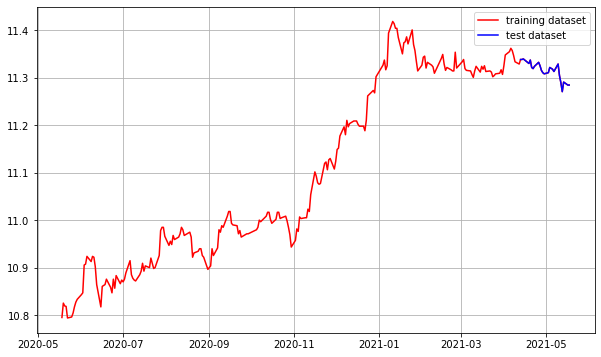

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
# 9:1 비율로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [ ]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기


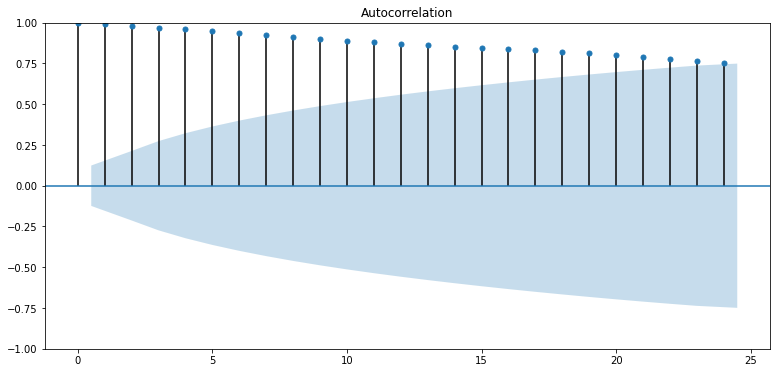

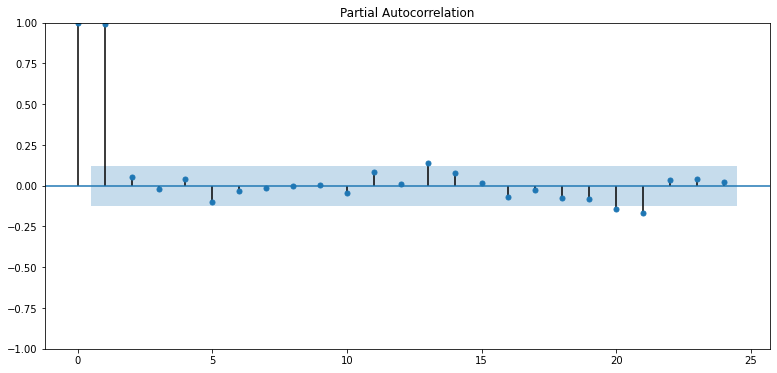

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

autocorrelation은 별로 특이점이 없어서 q=0로 두고, partial Autocorrelation에서 p = 1 이후로 작아졌기 때문에 p = 1로 두겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


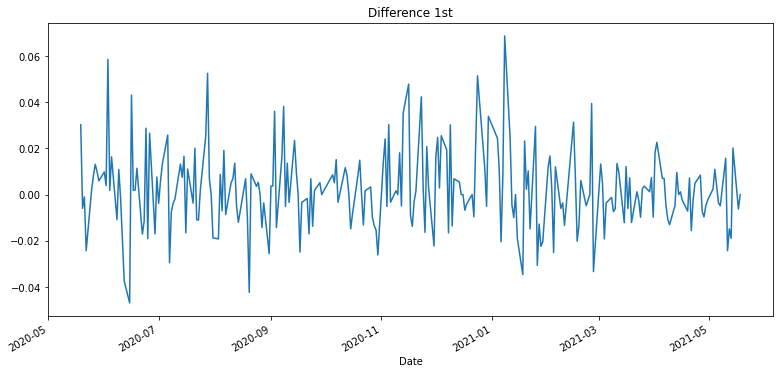

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


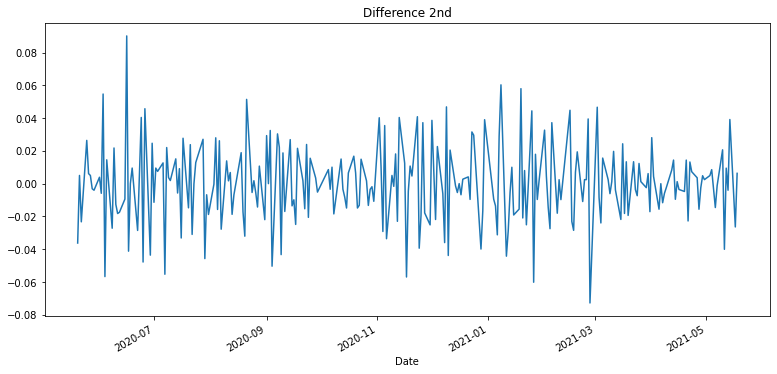

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

차분을 하지 않아도 안정적인 시계열이 나타나므로, d = 0로 두겠습니다.

## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)


In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 0)) # 모수는 이전 그래프를 참고 (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Tue, 26 Jul 2022   AIC                          -1158.817
Time:                        12:58:33   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

훈련결과를 시각화했습니다.

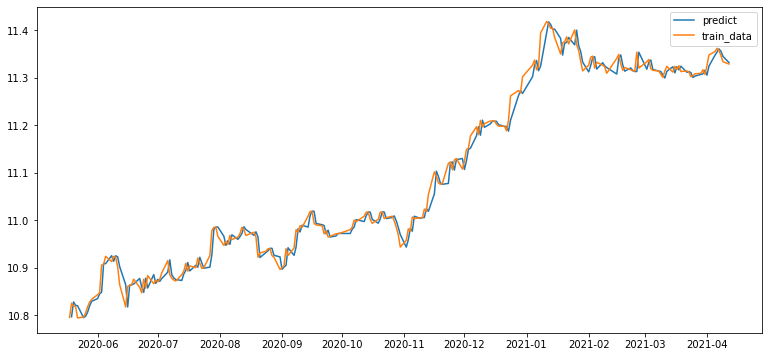

In [ ]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

훈련값과 예측값이 잘 맞는것 같습니다.

In [ ]:
len(test_data)

25

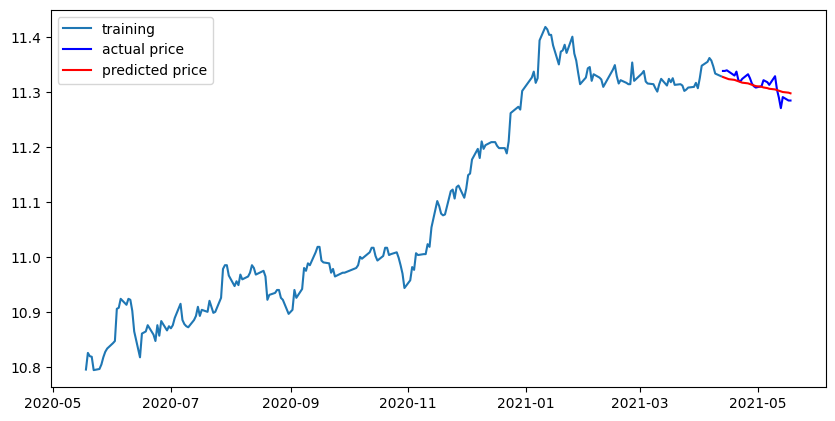

In [ ]:
model = ARIMA(train_data, order=(2, 0, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1052831.395368831
MAE:  840.3252917506366
RMSE:  1026.0757259426962
MAPE: 1.02%


mape 기준 1.02% 정도의 오차율을 보였습니다. 잘 맞는 예측 모델이라고 생각합니다.

참고) 여기서 모수 p = 1이라고 처음에 설정했는데, 값을 대입해 보다 보니 p = 2가 더 mape값을 더 낮췄습니다. 이유는 모르겠습니다..  
그래서 p = 2로 예측 모델을 만들었습니다.

---  
---

## STEP 7 : 다른 주식 종목 예측해 보기

* Google, netflix, tesla! 세개의 주식 종목을 예측해 보겠습니다.

### 💻 GOOGLE


#### STEP 1 : 시계열 데이터 준비

In [ ]:
goog = '/content/drive/MyDrive/dataset/GOOG.csv'
df_goog = ReadData(goog)
df_goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-26,138.250000,139.712997,137.651001,139.644501,139.644501,23052000
2021-07-27,140.011002,140.011002,135.100006,136.796494,136.796494,42164000
2021-07-28,138.561996,139.675995,136.350006,136.381500,136.381500,54688000
2021-07-29,136.380600,137.151505,136.138000,136.540497,136.540497,19284000
2021-07-30,135.511002,135.771347,134.814194,135.220993,135.220993,23954000


In [ ]:
gc = df_goog['Close']
print(type(gc))
gc.head()

<class 'pandas.core.series.Series'>


Date
2021-07-26    139.644501
2021-07-27    136.796494
2021-07-28    136.381500
2021-07-29    136.540497
2021-07-30    135.220993
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행

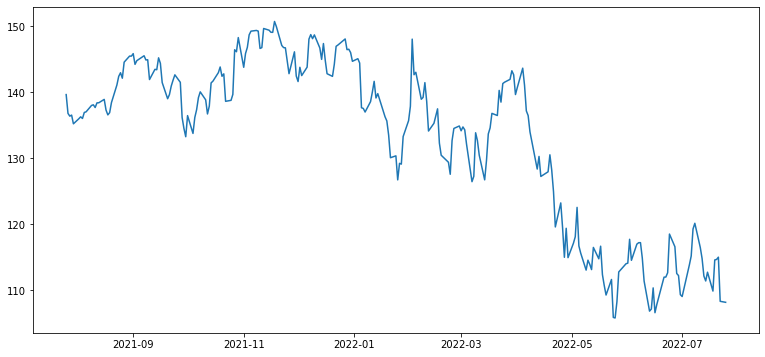

In [ ]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(gc)

불안정한 데이터입니다!

In [ ]:
gc[gc.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없네요!

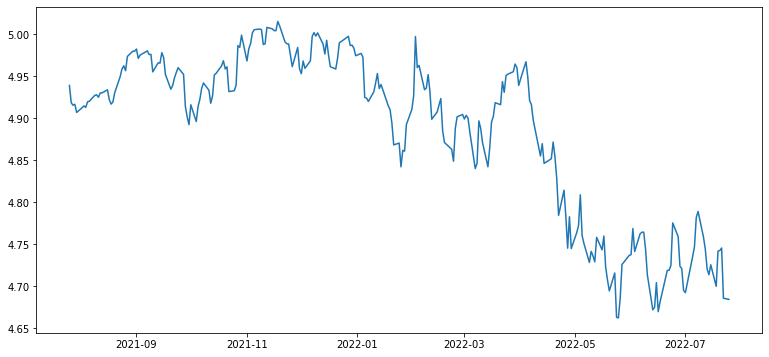

In [ ]:
gc_log = np.log(gc)
plt.plot(gc_log)

y축 단위를 보세요! 많이 줄였습니다.

#### STEP 3 : 시계열 안정성 분석

이동평균그래프와 adfuller를 통해 안정성 여부를 체크해 보겠습니다.


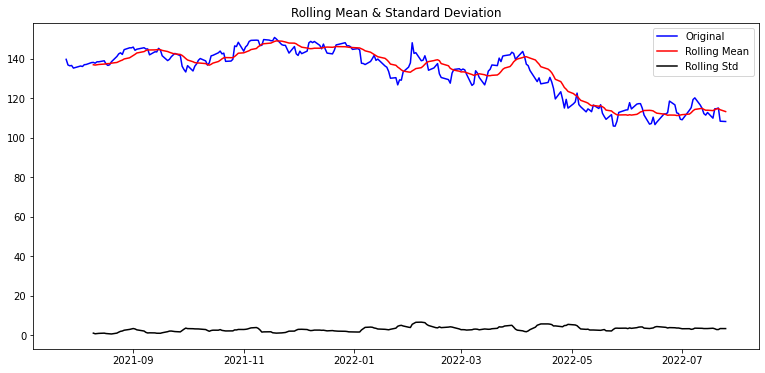

In [ ]:
plot_rolling_statistics(gc, window=12)

로그 취하기 전 그래프를 비교하기 위해 rolling mean, standard를 시각화했습니다.

In [ ]:
augmented_dickey_fuller_test(gc)

Results of Dickey-Fuller Test:
Test Statistic                  -1.048625
p-value                          0.735119
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


아직 p - value값이 0.5 이상인 것을 보니 불안정하군요

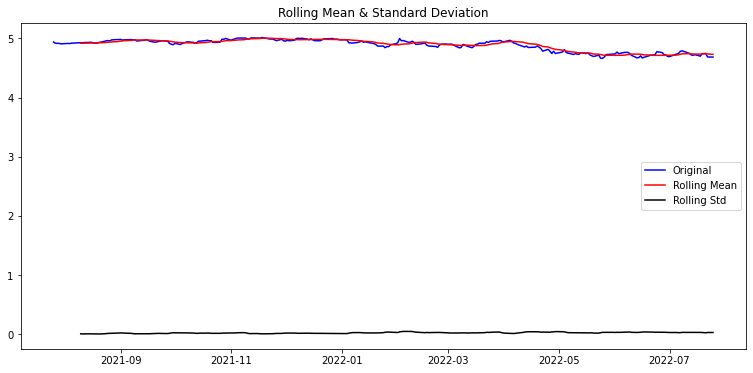

Results of Dickey-Fuller Test:
Test Statistic                  -1.004317
p-value                          0.751686
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


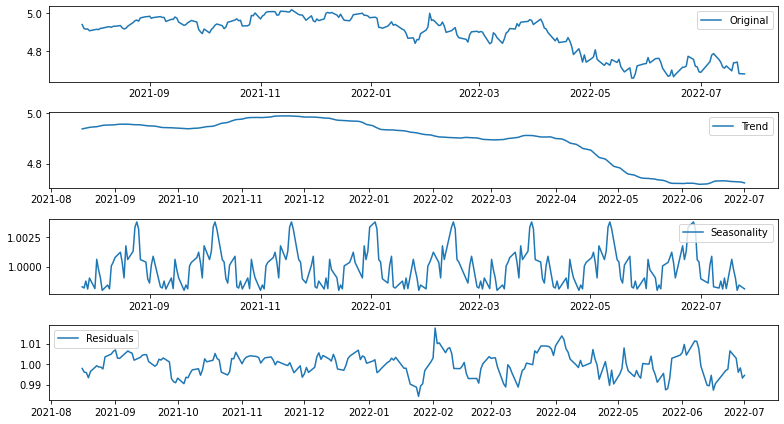

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(gc_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(gc_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(gc_log, model='multiplicative', period = 30) 
# model = 'additive' or 'multiplicative' 
# additive = 레벨+트렌드+계절성+잡음 
# multiplicative = 레벨*트렌드*계절성*잡음
# period = '주기' 근데이제 일별 데이터라서 30으로 둔 듯, 월별 데이터면 12로 둘듯.

trend_gc = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_gc = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_gc = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(gc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_gc, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_gc,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_gc, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

이동평균을 구해서 로그값에서 빼준 값입니다. 계절성을 상쇄해서 그래프가 stationary 해졌는데, 아직은 안정적이진 않은 것 같습니다.!!!

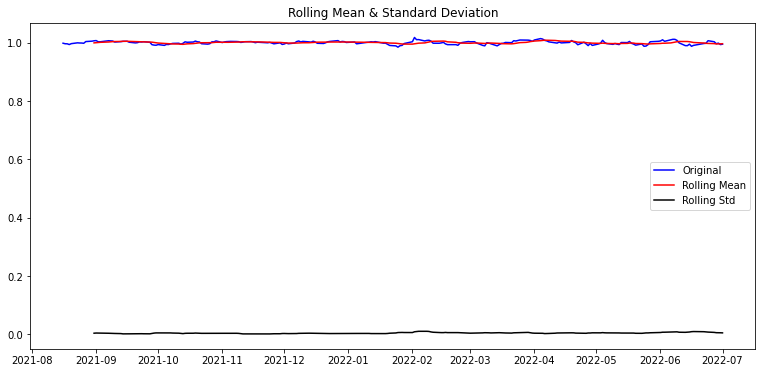

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_gc)

In [ ]:
residual_gc.dropna(inplace=True)
augmented_dickey_fuller_test(residual_gc)

Results of Dickey-Fuller Test:
Test Statistic                  -5.430686
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


p-value가 굉장히 낮아졌네요

#### STEP 4 : 학습, 테스트 데이터셋 생성

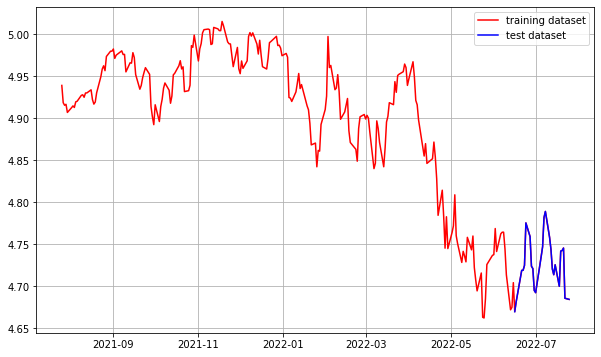

In [ ]:
train_data_gc, test_data_gc = gc_log[:int(len(gc_log)*0.9)], gc_log[int(len(gc_log)*0.9):]
# 9:1 비율로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(gc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_gc, c='b', label='test dataset')
plt.legend()

In [ ]:
print(gc_log[:2])
print(train_data_gc.shape)
print(test_data_gc.shape)

Date
2021-07-26    4.939100
2021-07-27    4.918494
Name: Close, dtype: float64
(226,)
(26,)


잘 분리되었습니다.~

#### STEP 5 : 적정 ARIMA 모수 찾기

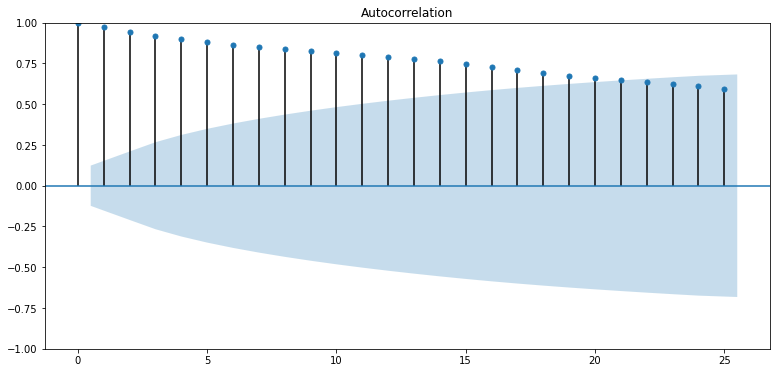

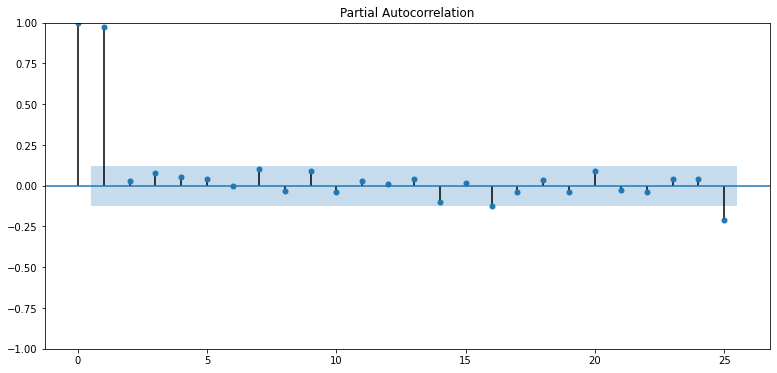

In [ ]:
plot_acf(gc_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(gc_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

partial Autocorrelation에서 1 이후로 작아졌기 때문에 p = 1로 두겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.651157e+01
p-value                        2.103582e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


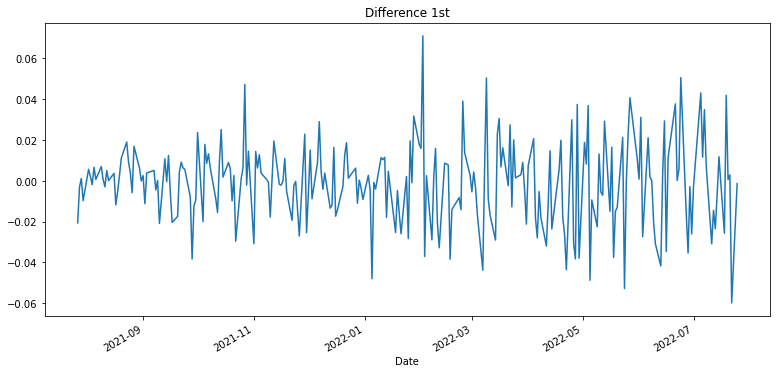

In [ ]:
# 1차 차분 구하기
diff_1_gc = gc_log.diff(periods=1).iloc[1:]
diff_1_gc.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_gc)

Results of Dickey-Fuller Test:
Test Statistic                -9.439653e+00
p-value                        4.933960e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


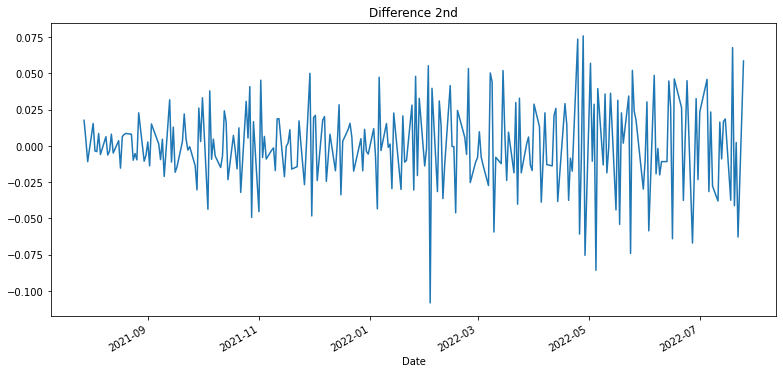

In [ ]:
# 2차 차분 구하기
diff_2_gc = diff_1_gc.diff(periods=1).iloc[1:]
diff_2_gc.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_gc)

1차 차분 시 가장 p-value값이 작았으므로 d = 1로 둡니다.

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model_gc = ARIMA(train_data_gc, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 (p,d,q)
fitted_m_gc = model_gc.fit() 

print(fitted_m_gc.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 572.547
Date:                Tue, 26 Jul 2022   AIC                          -1137.095
Time:                        12:58:37   BIC                          -1123.413
Sample:                             0   HQIC                         -1131.573
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8671      0.102     47.758      0.000       4.667       5.067
ar.L1          0.9893      0.013     78.293      0.000       0.964       1.014
ma.L1         -0.0427      0.062     -0.692      0.4

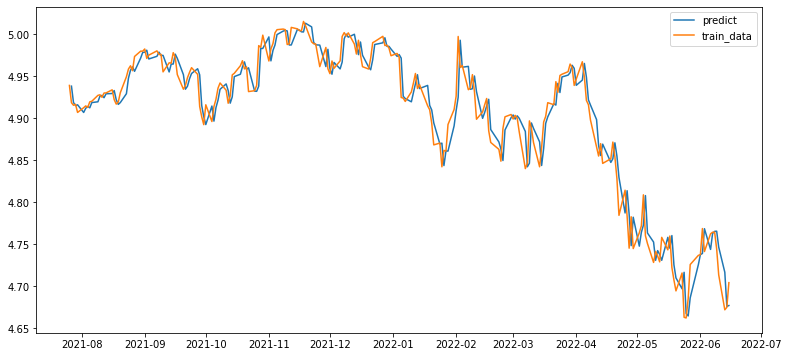

In [ ]:
fitted_m_gc = fitted_m_gc.predict()
fitted_m_gc = fitted_m_gc.drop(fitted_m_gc.index[0])
plt.plot(fitted_m_gc, label='predict')
plt.plot(train_data_gc, label='train_data')
plt.legend()

훈련값과 예측값이 잘 맞는 것 같습니다.

In [ ]:
len(test_data_gc)

26

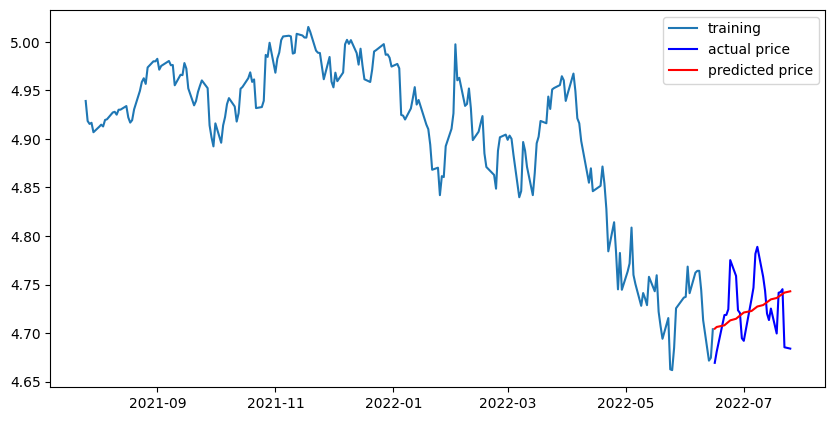

In [ ]:
model_gc = ARIMA(train_data_gc, order=(1, 0, 1))  # p값을 14으로 테스트
fitted_m_gc = model_gc.fit() 
# Forecast : 결과가 fc에 담깁니다. 
fc_gc = fitted_m_gc.forecast(len(test_data_gc), alpha=0.05)  # 95% conf
fc_gc = np.array(fc_gc)
# Make as pandas series
fc_series_gc = pd.Series(fc_gc, index=test_data_gc.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_gc, label='training')
plt.plot(test_data_gc, c='b', label='actual price')
plt.plot(fc_series_gc, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_gc = mean_squared_error(np.exp(test_data_gc), np.exp(fc_gc))
print('MSE: ', mse_gc)

mae_gc = mean_absolute_error(np.exp(test_data_gc), np.exp(fc_gc))
print('MAE: ', mae_gc)

rmse_gc = math.sqrt(mean_squared_error(np.exp(test_data_gc), np.exp(fc_gc)))
print('RMSE: ', rmse_gc)

mape_gc = np.mean(np.abs(np.exp(fc_gc) - np.exp(test_data_gc))/np.abs(np.exp(test_data_gc)))
print('MAPE: {:.2f}%'.format(mape_gc*100))

MSE:  13.268581755901026
MAE:  2.881801964671397
RMSE:  3.6426064508674316
MAPE: 2.55%


역시 구글! 현재 테스트 데이터인 기간이 주식 폭락 후 안정화 된 기간이라서 ,,? 잘 나온듯 싶습니다. 구글은 변동이 거의 없었죠 

---

### 🎥 NETFLX


#### STEP 1 : 시계열 데이터 준비

In [ ]:
nflx = '/content/drive/MyDrive/dataset/NFLX.csv'
df_nflx = ReadData(nflx)
df_nflx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-26,514.380005,521.130005,509.010010,516.489990,516.489990,2254500
2021-07-27,518.080017,521.950012,512.049988,518.909973,518.909973,2759000
2021-07-28,521.820007,524.469971,516.979980,519.299988,519.299988,2390500
2021-07-29,519.960022,520.780029,513.789978,514.250000,514.250000,1736000
2021-07-30,512.690002,519.789978,510.959991,517.570007,517.570007,2537100


In [ ]:
nc = df_nflx['Close']
print(type(nc))
nc.head()

<class 'pandas.core.series.Series'>


Date
2021-07-26    516.489990
2021-07-27    518.909973
2021-07-28    519.299988
2021-07-29    514.250000
2021-07-30    517.570007
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행

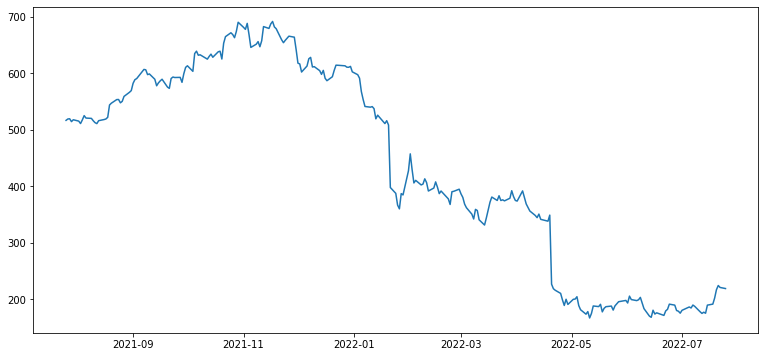

In [ ]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(nc)

올 초에 폭락했네요.. 손절하길 잘했습니다.

In [ ]:
nc[nc.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없네요!

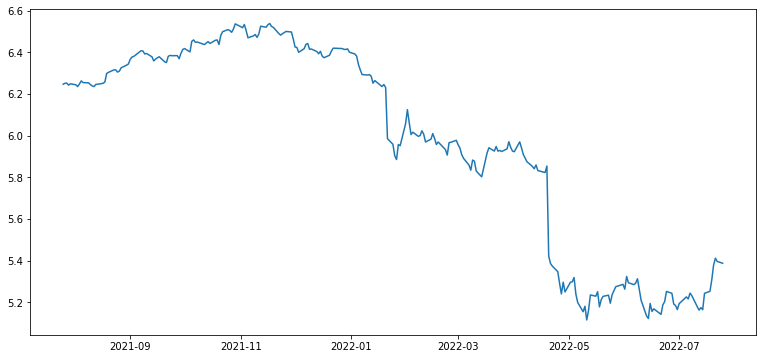

In [ ]:
nc_log = np.log(nc)
plt.plot(nc_log)

y축 단위를 보세요! 많이 줄였습니다.

#### STEP 3 : 시계열 안정성 분석

이동평균그래프와 adfuller를 통해 안정성 여부를 체크해 보겠습니다.


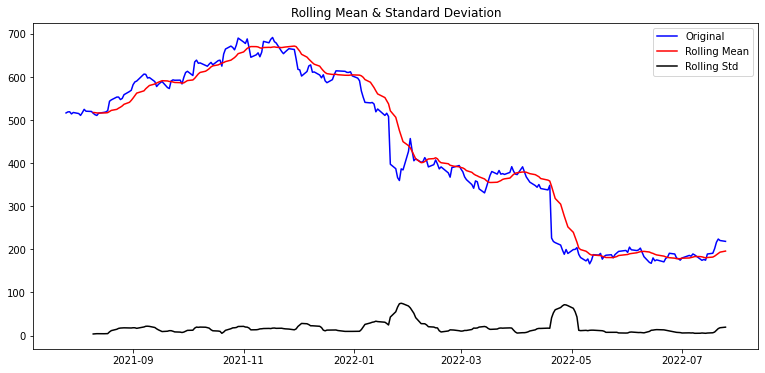

In [ ]:
plot_rolling_statistics(nc, window=12)

로그 취하기 전 그래프를 비교하기 위해 rolling mean, standard를 시각화했습니다.

In [ ]:
augmented_dickey_fuller_test(nc)

Results of Dickey-Fuller Test:
Test Statistic                  -0.142319
p-value                          0.945057
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


아직 p - value값이 0.5 이상인 것을 보니 불안정하군요

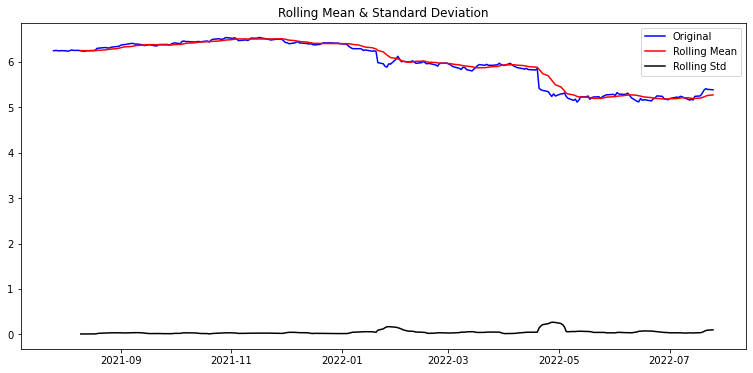

Results of Dickey-Fuller Test:
Test Statistic                  -0.265804
p-value                          0.930210
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


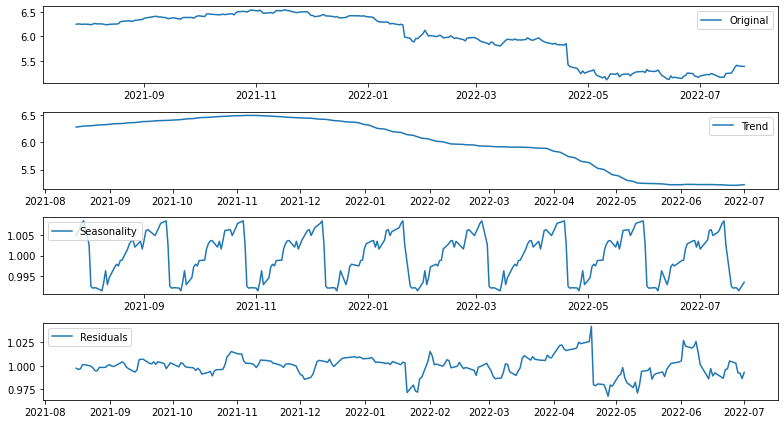

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(nc_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(nc_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(nc_log, model='multiplicative', period = 30) 
# model = 'additive' or 'multiplicative' 
# additive = 레벨+트렌드+계절성+잡음 
# multiplicative = 레벨*트렌드*계절성*잡음
# period = '주기' 근데이제 일별 데이터라서 30으로 둔 듯, 월별 데이터면 12로 둘듯.

trend_nc = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_nc = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_nc = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(nc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_nc, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_nc,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_nc, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

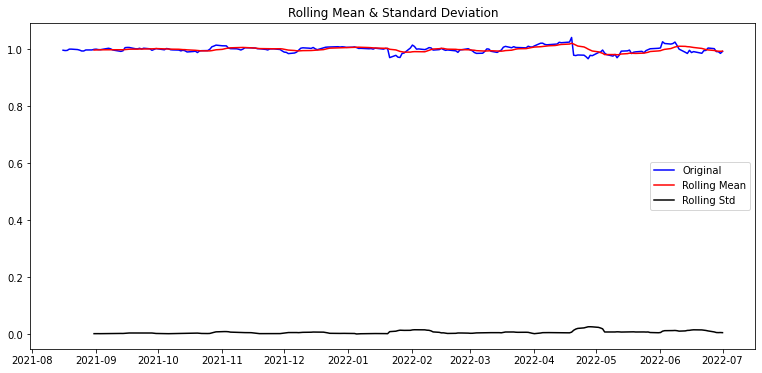

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_nc)

In [ ]:
residual_nc.dropna(inplace=True)
augmented_dickey_fuller_test(residual_nc)

Results of Dickey-Fuller Test:
Test Statistic                  -4.935944
p-value                          0.000030
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


p-value가 굉장히 낮아졌네요

#### STEP 4 : 학습, 테스트 데이터셋 생성

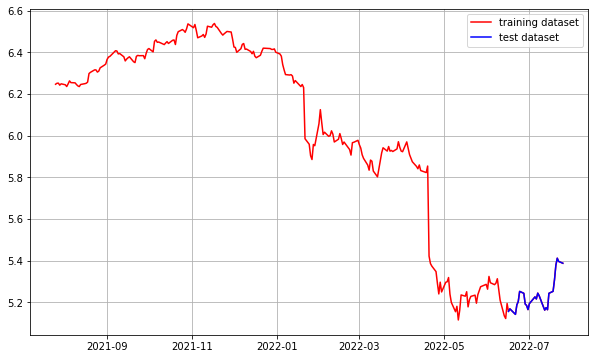

In [ ]:
train_data_nc, test_data_nc = nc_log[:int(len(nc_log)*0.9)], nc_log[int(len(nc_log)*0.9):]
# 9:1 비율로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(nc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_nc, c='b', label='test dataset')
plt.legend()

In [ ]:
print(nc_log[:2])
print(train_data_nc.shape)
print(test_data_nc.shape)

Date
2021-07-26    6.247056
2021-07-27    6.251730
Name: Close, dtype: float64
(226,)
(26,)


잘 분리되었습니다.~

#### STEP 5 : 적정 ARIMA 모수 찾기

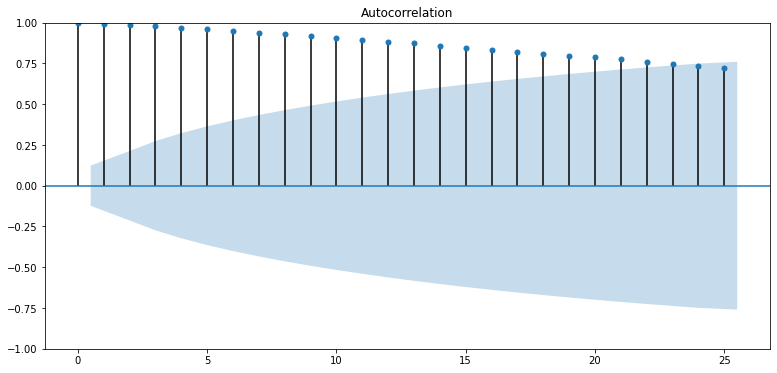

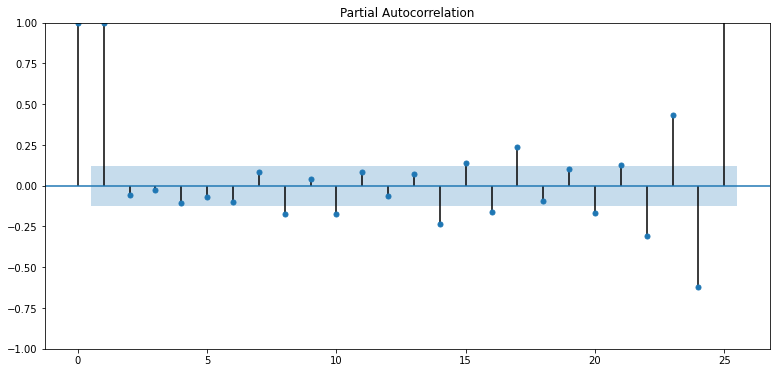

In [ ]:
plot_acf(nc_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(nc_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

partial Autocorrelation에서 1 이후로 작아졌기 때문에 p = 1로 두겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.496271e+01
p-value                        1.232799e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


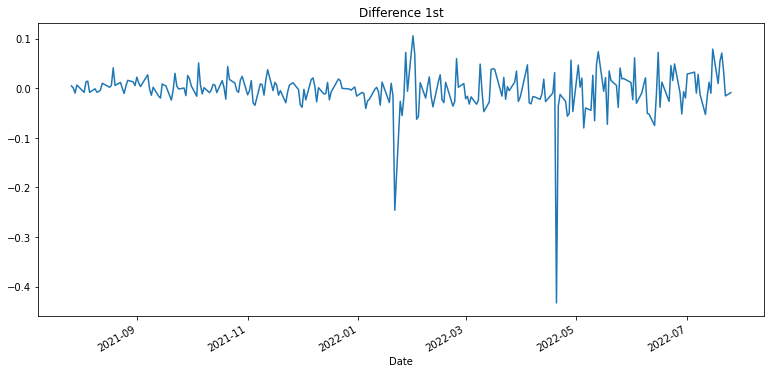

In [ ]:
# 1차 차분 구하기
diff_1_nc = nc_log.diff(periods=1).iloc[1:]
diff_1_nc.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_nc)

Results of Dickey-Fuller Test:
Test Statistic                -8.449526e+00
p-value                        1.677025e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


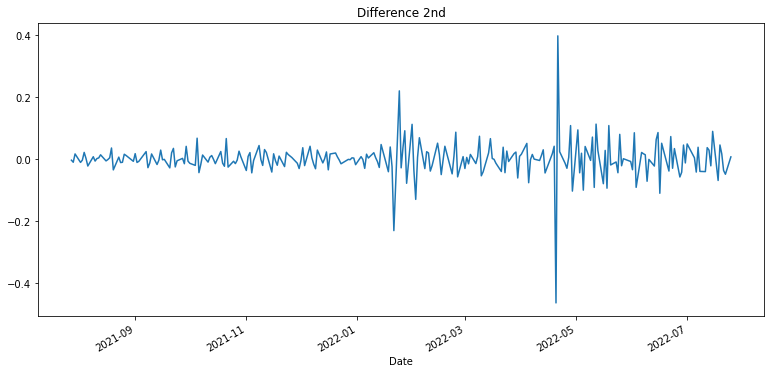

In [ ]:
# 2차 차분 구하기
diff_2_nc = diff_1_nc.diff(periods=1).iloc[1:]
diff_2_nc.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_nc)

1차 차분 시 가장 p-value값이 작았으므로 d = 1로 둡니다.

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model_nc = ARIMA(train_data_nc, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 (p,d,q)
fitted_m_nc = model_nc.fit() 

print(fitted_m_nc.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 386.919
Date:                Tue, 26 Jul 2022   AIC                           -765.838
Time:                        12:58:42   BIC                           -752.156
Sample:                             0   HQIC                          -760.316
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8273      0.595      9.798      0.000       4.662       6.993
ar.L1          0.9961      0.009    110.422      0.000       0.978       1.014
ma.L1          0.0529      0.103      0.513      0.6

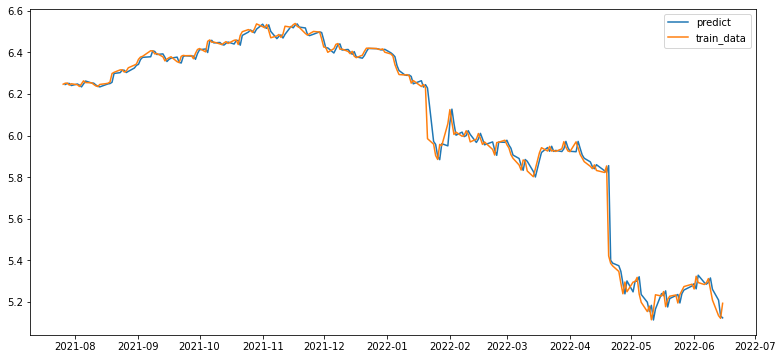

In [ ]:
fitted_m_nc = fitted_m_nc.predict()
fitted_m_nc = fitted_m_nc.drop(fitted_m_nc.index[0])
plt.plot(fitted_m_nc, label='predict')
plt.plot(train_data_nc, label='train_data')
plt.legend()

훈련값과 예측값이 잘 맞는 것 같습니다.

In [ ]:
len(test_data_nc)

26

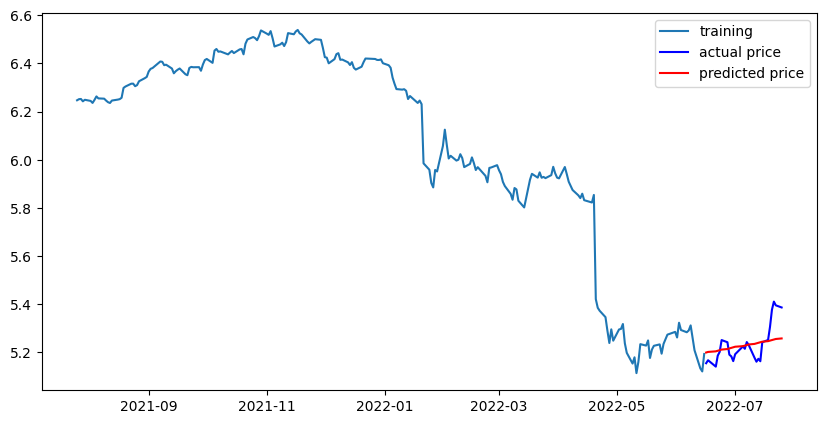

In [ ]:
model_nc = ARIMA(train_data_nc, order=(1, 0, 1))  # p값을 14으로 테스트
fitted_m_nc = model_nc.fit() 
# Forecast : 결과가 fc에 담깁니다. 
fc_nc = fitted_m_nc.forecast(len(test_data_nc), alpha=0.05)  # 95% conf
fc_nc = np.array(fc_nc)
# Make as pandas series
fc_series_nc = pd.Series(fc_nc, index=test_data_nc.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_nc, label='training')
plt.plot(test_data_nc, c='b', label='actual price')
plt.plot(fc_series_nc, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_nc = mean_squared_error(np.exp(test_data_nc), np.exp(fc_nc))
print('MSE: ', mse_nc)

mae_nc = mean_absolute_error(np.exp(test_data_nc), np.exp(fc_nc))
print('MAE: ', mae_nc)

rmse_nc = math.sqrt(mean_squared_error(np.exp(test_data_nc), np.exp(fc_nc)))
print('RMSE: ', rmse_nc)

mape_nc = np.mean(np.abs(np.exp(fc_nc) - np.exp(test_data_nc))/np.abs(np.exp(test_data_nc)))
print('MAPE: {:.2f}%'.format(mape_nc*100))

MSE:  175.25526088653695
MAE:  9.694645753043073
RMSE:  13.23840099432469
MAPE: 4.96%


짜잔!(?) 4.96%로 세 종목중에 제일 낮긴 하지만 netflix 데이터 자체가 코로나 수혜로 많이 올랐다가 최근 실적이 예상보다 낮게 나와서 많이 떨어졌던 종목이라,, 불안정한 데이터라서 조금 낮다고 생각됩니다!!
 

---

### 🏁 TESLA

#### STEP 1 : 시계열 데이터 준비

In [ ]:
tsla = '/content/drive/MyDrive/dataset/TSLA.csv'
df_tsla = ReadData(tsla)
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-26,650.969971,668.200012,647.109985,657.619995,657.619995,25336600
2021-07-27,663.400024,666.500000,627.239990,644.780029,644.780029,32813300
2021-07-28,647.000000,654.969971,639.400024,646.979980,646.979980,16006600
2021-07-29,649.789978,683.690002,648.799988,677.349976,677.349976,30394600
2021-07-30,671.760010,697.530029,669.000000,687.200012,687.200012,29656400


In [ ]:
tc = df_tsla['Close']
print(type(tc))
tc.head()

<class 'pandas.core.series.Series'>


Date
2021-07-26    657.619995
2021-07-27    644.780029
2021-07-28    646.979980
2021-07-29    677.349976
2021-07-30    687.200012
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행

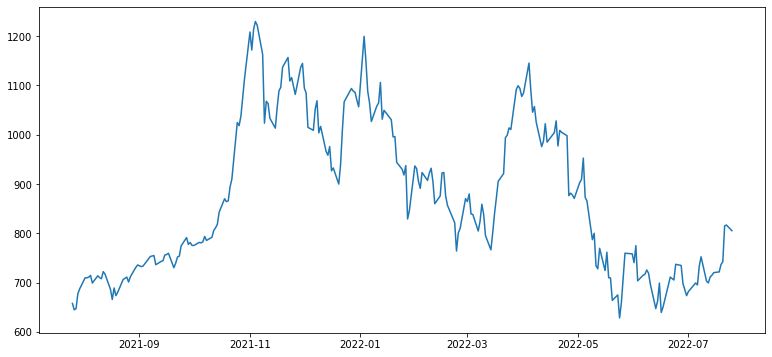

In [ ]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(tc)

불안정한 시계열 데이터네요,

In [ ]:
tc[tc.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없네요!

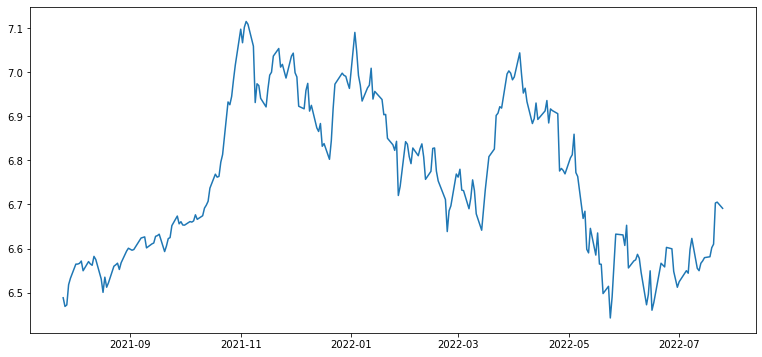

In [ ]:
tc_log = np.log(tc)
plt.plot(tc_log)

y축 단위를 보세요! 많이 줄였습니다.

#### STEP 3 : 시계열 안정성 분석

이동평균그래프와 adfuller를 통해 안정성 여부를 체크해 보겠습니다.


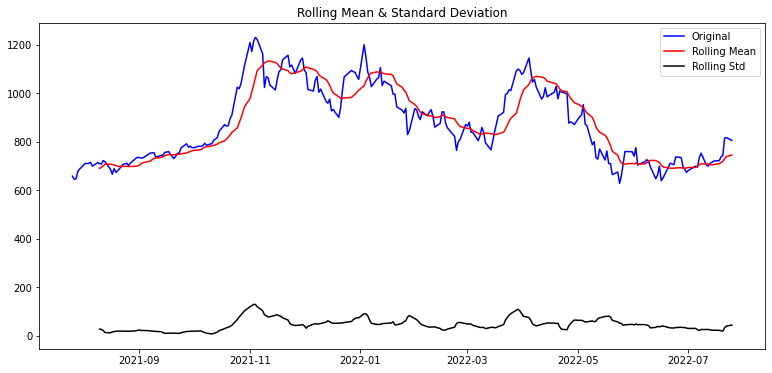

In [ ]:
plot_rolling_statistics(tc, window=12)

로그 취하기 전 그래프를 비교하기 위해 rolling mean, standard를 시각화했습니다.

In [ ]:
augmented_dickey_fuller_test(tc)

Results of Dickey-Fuller Test:
Test Statistic                  -1.921805
p-value                          0.321874
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


아직 p - value값이 0.5 이상인 것을 보니 불안정하군요

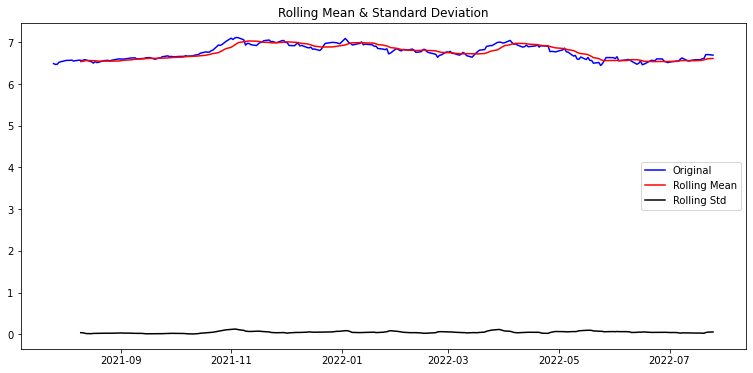

Results of Dickey-Fuller Test:
Test Statistic                  -1.887538
p-value                          0.337946
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


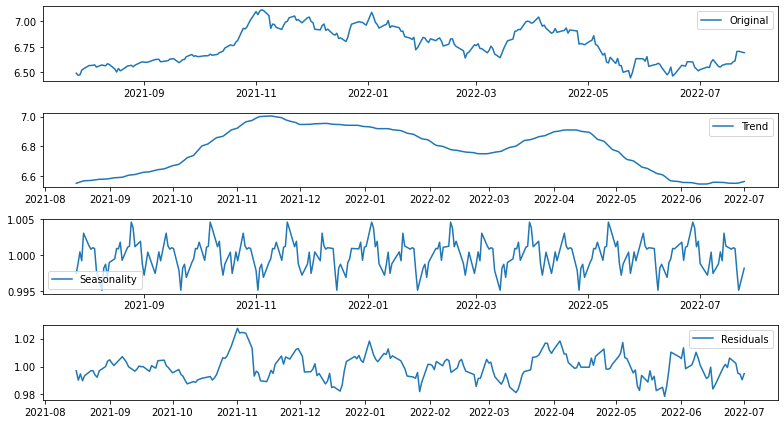

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(tc_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(tc_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tc_log, model='multiplicative', period = 30) 
# model = 'additive' or 'multiplicative' 
# additive = 레벨+트렌드+계절성+잡음 
# multiplicative = 레벨*트렌드*계절성*잡음
# period = '주기' 근데이제 일별 데이터라서 30으로 둔 듯, 월별 데이터면 12로 둘듯.

trend_tc = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_tc = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_tc = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(tc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_tc, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_tc,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_tc, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

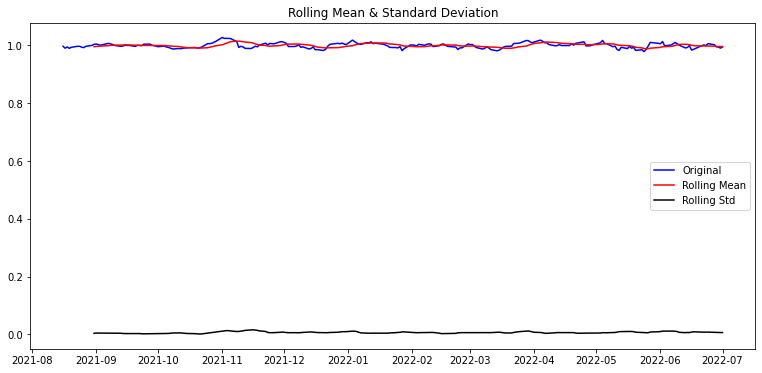

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_tc)

In [ ]:
residual_tc.dropna(inplace=True)
augmented_dickey_fuller_test(residual_tc)

Results of Dickey-Fuller Test:
Test Statistic                  -5.607918
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


p-value가 굉장히 낮아졌네요

#### STEP 4 : 학습, 테스트 데이터셋 생성

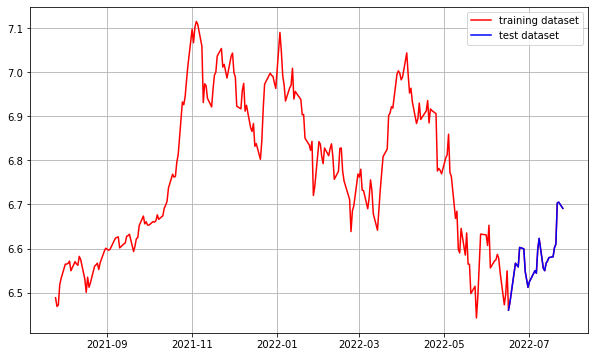

In [ ]:
train_data_tc, test_data_tc = tc_log[:int(len(tc_log)*0.9)], tc_log[int(len(tc_log)*0.9):]
# 9:1 비율로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_tc, c='b', label='test dataset')
plt.legend()

In [ ]:
print(tc_log[:2])
print(train_data_tc.shape)
print(test_data_tc.shape)

Date
2021-07-26    6.488627
2021-07-27    6.468909
Name: Close, dtype: float64
(226,)
(26,)


잘 분리되었습니다.~

#### STEP 5 : 적정 ARIMA 모수 찾기

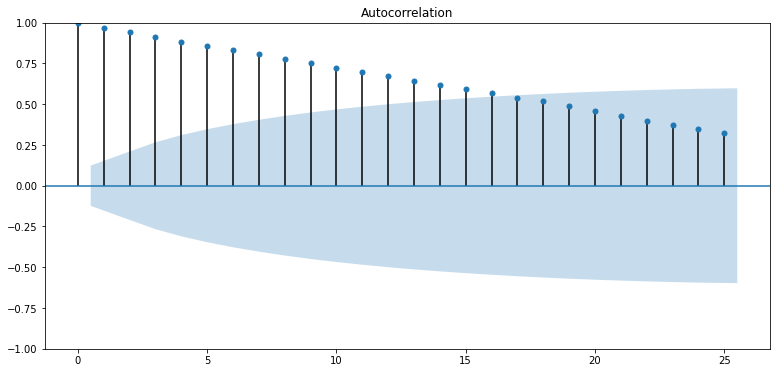

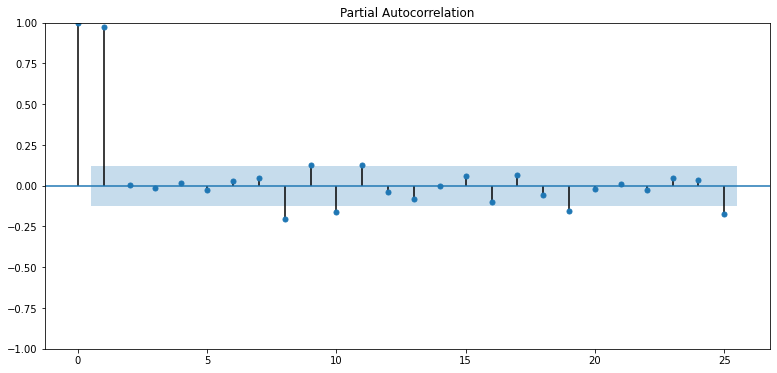

In [ ]:
plot_acf(tc_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(tc_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

partial Autocorrelation에서 1 이후로 작아졌기 때문에 p = 1로 두겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                  -5.008050
p-value                          0.000021
#Lags Used                       9.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


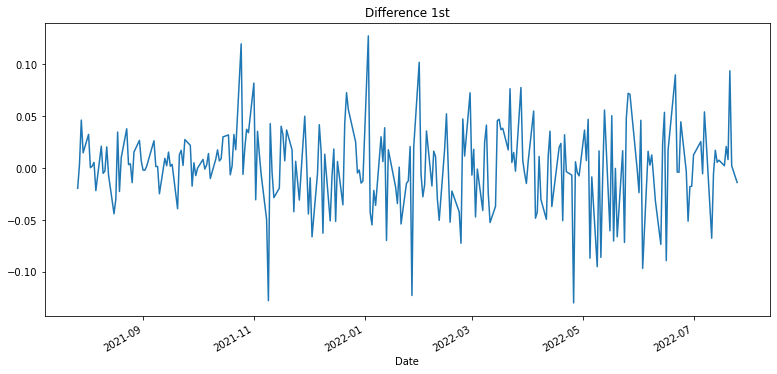

In [ ]:
# 1차 차분 구하기
diff_1_tc = tc_log.diff(periods=1).iloc[1:]
diff_1_tc.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_tc)

Results of Dickey-Fuller Test:
Test Statistic                -6.836132e+00
p-value                        1.840562e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


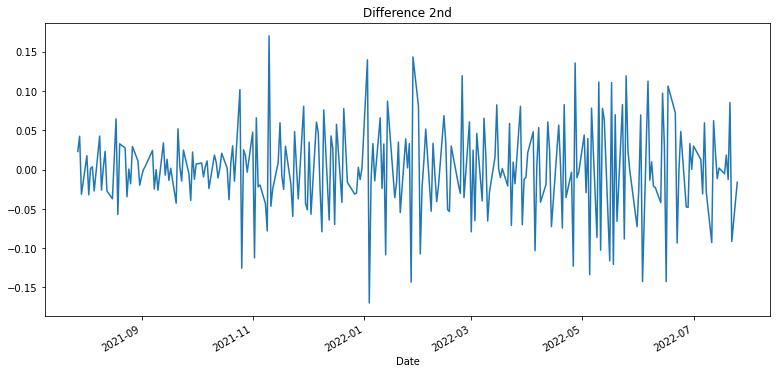

In [ ]:
# 2차 차분 구하기
diff_2_tc = diff_1_tc.diff(periods=1).iloc[1:]
diff_2_tc.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_tc)

2차 차분 시 가장 p-value값이 작았으므로 d = 2로 둡니다.

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model_tc = ARIMA(train_data_tc, order=(1, 0, 2)) # 모수는 이전 그래프를 참고 (p,d,q)
fitted_m_tc = model_tc.fit() 

print(fitted_m_tc.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 409.492
Date:                Tue, 26 Jul 2022   AIC                           -808.983
Time:                        12:58:47   BIC                           -791.881
Sample:                             0   HQIC                          -802.082
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7090      0.101     66.478      0.000       6.511       6.907
ar.L1          0.9753      0.016     61.016      0.000       0.944       1.007
ma.L1         -0.0064      0.079     -0.081      0.9

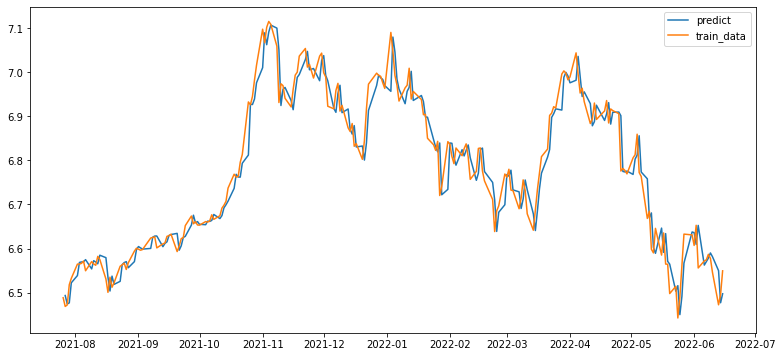

In [ ]:
fitted_m_tc = fitted_m_tc.predict()
fitted_m_tc = fitted_m_tc.drop(fitted_m_tc.index[0])
plt.plot(fitted_m_tc, label='predict')
plt.plot(train_data_tc, label='train_data')
plt.legend()

훈련값과 예측값이 잘 맞는 것 같습니다.

In [ ]:
len(test_data_tc)

26

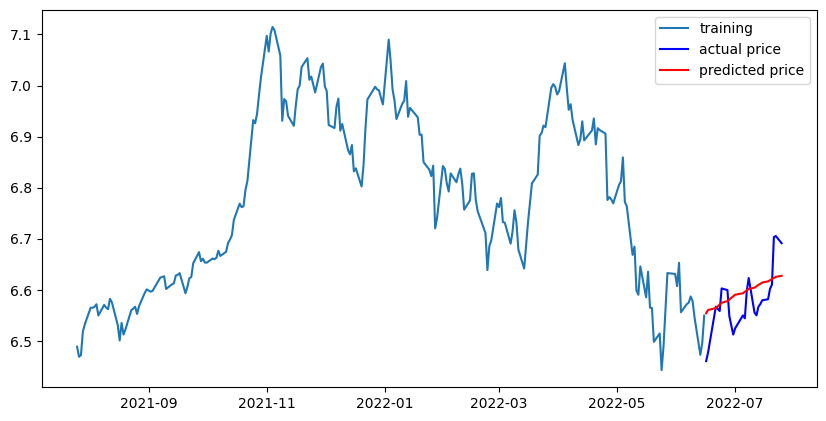

In [ ]:
model_tc = ARIMA(train_data_tc, order=(1, 0, 2))  # p값을 14으로 테스트
fitted_m_tc = model_tc.fit() 
# Forecast : 결과가 fc에 담깁니다. 
fc_tc = fitted_m_tc.forecast(len(test_data_tc), alpha=0.05)  # 95% conf
fc_tc = np.array(fc_tc)
# Make as pandas series
fc_series_tc = pd.Series(fc_tc, index=test_data_tc.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_tc, label='training')
plt.plot(test_data_tc, c='b', label='actual price')
plt.plot(fc_series_tc, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_tc = mean_squared_error(np.exp(test_data_tc), np.exp(fc_tc))
print('MSE: ', mse_tc)

mae_tc = mean_absolute_error(np.exp(test_data_tc), np.exp(fc_tc))
print('MAE: ', mae_tc)

rmse_tc = math.sqrt(mean_squared_error(np.exp(test_data_tc), np.exp(fc_tc)))
print('RMSE: ', rmse_tc)

mape_tc = np.mean(np.abs(np.exp(fc_tc) - np.exp(test_data_tc))/np.abs(np.exp(test_data_tc)))
print('MAPE: {:.2f}%'.format(mape_tc*100))

MSE:  1306.6731617940593
MAE:  30.6932796708618
RMSE:  36.147934405634565
MAPE: 4.29%


4%대로 비교적 낮게 나왔습니다.! 오르락 내리락이 심했던 그래프였는데도 불구하고 잘 맞춰줬습니다.

---  
---

># itertools

구글링을 해 보니 최적의 (p,d,q)값을 찾기 위해서 사용하는 방법이 몇 가지 있었습니다. 참고자료 [1]  
volume에 pdq가 0부터 4까지의 값일 때 aic(Akaike information criterion)이 얼마정도 되는지 프린트 해보고 그 중 가장 낮은 값을 가진 모수를 사용하는 방법을 먼저 사용해 보겠습니다.

In [ ]:
import itertools

p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_nc = ARIMA(train_data_nc, order=(param))
        fitted_m_nc = model_nc.fit()
        print(param, fitted_m_nc.aic)
    except:
        continue

(0, 0, 0) 265.30129616310955
(0, 0, 1) -26.496372331154163
(0, 0, 2) -211.11818577135364
(0, 0, 3) -363.415779634602
(0, 0, 4) -435.17985583909785
(0, 1, 0) -772.3643167659386
(0, 1, 1) -770.9508555939133
(0, 1, 2) -769.0169753839048
(0, 1, 3) -767.9669506498008
(0, 1, 4) -766.2135995851997
(0, 2, 0) -626.0379954944661
(0, 2, 1) -764.1870033767929
(0, 2, 2) -762.4133544220833
(0, 2, 3) -760.4133938502152
(0, 2, 4) -758.9425757823785
(0, 3, 0) -380.9231920352317
(0, 3, 1) -614.8144927096537
(0, 3, 2) -746.5198592790705
(0, 3, 3) -745.0367844620162
(0, 3, 4) -743.0539642513452
(0, 4, 0) -112.65590206395693
(0, 4, 1) -370.71204837786394
(0, 4, 2) -598.1521107142242
(0, 4, 3) -719.6030892579297
(0, 4, 4) -716.7925128279456
(1, 0, 0) -767.1977291073877
(1, 0, 1) -765.8377060801929
(1, 0, 2) -763.9229844204413
(1, 0, 3) -762.9458947154917
(1, 0, 4) -761.1550320140373
(1, 1, 0) -770.9724165360701
(1, 1, 1) -769.3442470377387
(1, 1, 2) -768.257893514563
(1, 1, 3) -773.0620175971467
(1, 1, 4) -

(3, 1, 3)에서  aic가 -774.502246457432 로 가장 낮으므로 한 번 이용해 보겠습니다.

mape 값이 5% 대로 개선되지 않았습니다. 한번 써본다는 것에 의의를 뒀습니다. (ㅋㅋ)

----

# 회고

1. 시간에 따라 달라지는 데이터를 시계열이라고 하고, 그것을 예측하는 방법과 tool은 따로 있다는 것을 배울 수 있었습니다.
2. mape 수치를 낮추기 위해서는 **시계열 데이터의 정상성이 무엇보다 중요**한 전제조건임을 느꼈습니다.  
    가장 불안정했던 netflix의 mape값이 가장 낮았습니다.
3. 추가로 가장 mape 값이 높았던 netflix 데이터에 **AIC**(Akaike information criterion) 값을 따져서 최적의 모수를 찾는 방법을 사용해 보았습니다.  
    오히려 mape 값이 커졌지만, 이런 방법도 있다는 것을 알 수 있었습니다.
4. LMS의 statsmodels 라이브러리 버전과 코랩 버전과 차이가 있어서 실행이 제대로 안 됐습니다. statsmodels 공식 문서를 찾아보고 여차저차 코드를 수정하다가 코랩 statsmodels 업그레이드를 하니 원활히 사용할 수 있었습니다. **버전체크 필수다!!**
5. 모수 선정할 때, **acf, pacf 그래프를 그려서 p, q값을 선정했는데 이게 절대적인 최적의 모수 값 선정방법은 아닌 것 같았습니다.** 그래프상의 p값보다 1을 더하거나 했을 때 더 좋은 결과가 나온 경우가 있었기 때문에 결과가 잘 안나올 때 해당 값을 그렇게 변화시켜주는 것도 괜찮다고 생각됩니다.
6. 실제로 가지고 있었던, 갖고있는(?) 종목을 시계열 분석으로 예측해보니 종목에 애착이 생기고(?) 학습에 잘 따라준 모델이 고맙습니다(?) 앞으로도 우상향이었으면 좋겠네요^^ 📈 재밌었습니다.

---

참고자료  
[1] https://happy-chipmunk.tistory.com/entry/Time-Series-Forecasting-2-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%8B%9C%EA%B3%84%EC%97%B4-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%8D%B8%EB%A7%81-ARIMA-Auto-regressive-integrated-moving-average-Auto-ARIMA